In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# 1. Import Dataset

In [2]:
# from poc_data import PocDataset

# poc_raw_dataset = PocDataset(num_cases=2**10)
# data_loader = torch.utils.data.DataLoader(poc_raw_dataset,batch_size=128)
# batch, event, time_to_event, _latent_variable = next(iter(data_loader))

# print(batch.shape)
# print(event.shape)
# print(time_to_event.shape)
# print(_latent_variable.shape)

### Data Exploration

In [3]:
#Take a look at the longitudional data

# plt.plot(np.array(batch[0][:int(time_to_event[0]),1]), batch[0][:int(time_to_event[0]),2])
# plt.plot(np.array(batch[1][:int(time_to_event[1]),1]), batch[1][:int(time_to_event[1]),2])
# plt.plot(np.array(batch[2][:int(time_to_event[2]),1]), batch[2][:int(time_to_event[2]),2])
# plt.plot(np.array(batch[3][:int(time_to_event[3]),1]), batch[3][:int(time_to_event[3]),2])
# plt.plot(np.array(batch[4][:int(time_to_event[4]),1]), batch[4][:int(time_to_event[4]),2])

# print(event[:5])
# print(time_to_event[:5])
# print(_latent_variable[:5])

# 2. Hyperparameters

In [4]:
DEVICE = 'cuda'

# 3. Defining The Model

# 4. Training the model

tensor([[ 0.0000, 16.2622, -0.2341],
        [ 0.0000, 16.8038, -0.3956],
        [ 0.0000, 17.3455, -0.4439],
        [ 0.0000, 17.8871, -0.3651],
        [ 0.0000, 18.4288, -0.1817],
        [ 0.0000, 18.9704,  0.0536],
        [ 0.0000, 19.5121,  0.2737],
        [ 0.0000, 20.0537,  0.4153],
        [ 0.0000, 20.5954,  0.4381],
        [ 0.0000, 21.1370,  0.3354]], device='cuda:0')
0.4448866844177246


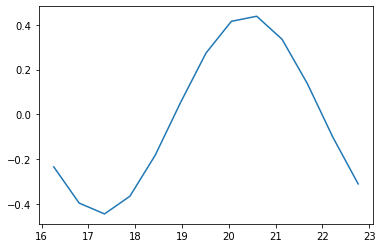

In [5]:
from poc_data import PocDataset

test_poc_raw_dataset = PocDataset(num_cases=1)
test_data_loader = torch.utils.data.DataLoader(test_poc_raw_dataset,batch_size=1)
test_batch, test_event, test_time_to_event, test_latent_variable = next(iter(test_data_loader))
test_batch = test_batch.to(DEVICE)

plt.plot(np.array(test_batch.cpu()[0][:int(test_time_to_event[0]),1]), test_batch.cpu()[0][:int(test_time_to_event[0]),2])
print(test_batch[0,:10])
print(test_latent_variable.item())

In [6]:
from torch.nn import MSELoss
from tqdm import trange, tqdm

from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
from dynamicDeepHit import EncoderRNN, AttnDecoderRNN, RegressionNetwork

poc_raw_dataset = PocDataset(num_cases=2**10)
data_loader = torch.utils.data.DataLoader(poc_raw_dataset,batch_size=1)

NUM_EPOCHS = 25

LEARNING_RATE_ENCODER = 0.001
LEARNING_RATE_DECODER = 0.001
LEARNING_RATE_REGRESS = 0.001

LOSS_3_AMPLIFIER = 1
LOSS_4_AMPLIFIER = 100

input_size = 3
output_size = input_size
MAX_LENGTH = 30
hidden_size_encoder = 512
hidden_size_regress = 128

# initialize model
encoder = EncoderRNN(input_size, hidden_size_encoder).to(DEVICE)
decoder = AttnDecoderRNN(hidden_size_encoder, output_size, MAX_LENGTH).to(DEVICE)
regress = RegressionNetwork(hidden_size_encoder, hidden_size_regress).to(DEVICE)

# intialize optimizer
optimizer_encoder = Adam(encoder.parameters(), lr=LEARNING_RATE_ENCODER)
optimizer_decoder = Adam(decoder.parameters(), lr=LEARNING_RATE_DECODER)
optimizer_regress = Adam(regress.parameters(), lr=LEARNING_RATE_REGRESS)
 
# initialize loss
mse_loss = MSELoss()
writer = SummaryWriter()

tensor([[ 0.0810, -0.0639, -0.0697],
        [ 0.0857, -0.0590, -0.0684],
        [ 0.0860, -0.0577, -0.0657],
        [ 0.0859, -0.0569, -0.0638],
        [ 0.0855, -0.0570, -0.0627],
        [ 0.0850, -0.0571, -0.0620],
        [ 0.0845, -0.0572, -0.0615],
        [ 0.0841, -0.0571, -0.0610],
        [ 0.0839, -0.0568, -0.0607],
        [ 0.0840, -0.0564, -0.0603]], device='cuda:0')
real lv was 0.444887, we estimated 0.520966


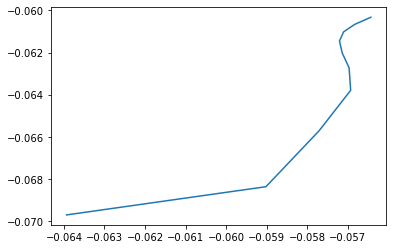

In [7]:
test_encoder_hidden_vector = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=DEVICE)
test_encoder_output_vector = torch.zeros(MAX_LENGTH, encoder.input_size, device=DEVICE)
test_encoder_hidden = encoder.initHidden(device=DEVICE)

for ei in range(test_batch.size(1)):
        test_encoder_input = test_batch[0][ei].view(1,1,-1)
        test_encoder_output, test_encoder_hidden = encoder(test_encoder_input, test_encoder_hidden)
        test_encoder_output_vector[ei] = test_encoder_output

test_last_measurement = test_batch[0][ei]
test_context_vector = decoder(test_last_measurement, test_encoder_hidden_vector)
test_estimated_latent_variable = regress(test_context_vector)

test_encoder_output_vector = test_encoder_output_vector.unsqueeze(0).detach()
plt.plot(np.array(test_encoder_output_vector.cpu()[0][0:10,1]), test_encoder_output_vector.cpu()[0][0:10,2])
print(test_encoder_output_vector[0,:10])
print("real lv was %f, we estimated %f" % (test_latent_variable.item(), test_estimated_latent_variable.item()))

In [8]:
# start training
for epoch in trange(NUM_EPOCHS):

  epoch_loss = 0

  for i, data in enumerate(data_loader):

    batch, event, time_to_event, _latent_variable = data

    batch = batch.to(DEVICE)
    _latent_variable = _latent_variable.to(DEVICE)

    optimizer_encoder.zero_grad()
    optimizer_decoder.zero_grad()
    optimizer_regress.zero_grad()

    encoder_hidden_vector = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=DEVICE)
    encoder_output_vector = torch.zeros(MAX_LENGTH, encoder.input_size, device=DEVICE)
    encoder_hidden = encoder.initHidden(device=DEVICE)

    for ei in range(batch.size(1)):
        encoder_input = batch[0][ei].view(1,1,-1)
        encoder_output, encoder_hidden = encoder(encoder_input, encoder_hidden)
        encoder_hidden_vector[ei] = encoder_hidden[0,0]
        encoder_output_vector[ei] = encoder_output

    last_measurement = batch[0][ei]
    context_vector = decoder(last_measurement, encoder_hidden_vector)

    estimated_latent_variable = regress(context_vector)
    
    loss3 = mse_loss(encoder_output_vector[:-1], batch.detach().squeeze(0)[1:])
    loss4 = mse_loss(estimated_latent_variable, _latent_variable)

    epoch_loss += LOSS_3_AMPLIFIER*loss3 + LOSS_4_AMPLIFIER*loss4

  writer.add_scalar('loss3', loss3.item(), epoch*len(data_loader) + i)
  writer.add_scalar('loss4', loss4.item(), epoch*len(data_loader) + i)

  epoch_loss.backward()

  optimizer_encoder.step()
  optimizer_regress.step()
  
  writer.add_scalar('loss_epoch', epoch_loss.item(), epoch)
print("av_epoch_train_loss=", epoch_loss.item()/len(data_loader))

  2%|▏         | 1/50 [00:14<11:55, 14.60s/it]

In [ ]:
plt.plot(np.array(test_batch.cpu()[0][:10,1]), test_batch.cpu()[0][:10,2])
print(test_batch.cpu()[0,:10])
print(test_latent_variable.item())

In [ ]:
test_encoder_hidden_vector = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=DEVICE)
test_encoder_output_vector = torch.zeros(MAX_LENGTH, encoder.input_size, device=DEVICE)
test_encoder_hidden = encoder.initHidden(device=DEVICE)

for ei in range(test_batch.size(1)):
        test_encoder_input = test_batch[0][ei].view(1,1,-1)
        test_encoder_output, test_encoder_hidden = encoder(test_encoder_input, test_encoder_hidden)
        test_encoder_output_vector[ei] = test_encoder_output

test_last_measurement = test_batch[0][ei]
test_context_vector = decoder(test_last_measurement, test_encoder_hidden_vector)
test_estimated_latent_variable = regress(test_context_vector)

test_encoder_output_vector = test_encoder_output_vector.unsqueeze(0).detach()
plt.plot(np.array(test_encoder_output_vector.cpu()[0][0:10,1]), test_encoder_output_vector.cpu()[0][0:10,2])
print(test_encoder_output_vector[0,:10])
print("real lv was %f, we estimated %f" % (test_latent_variable.item(), test_estimated_latent_variable.item()))